# Trabalho Prático 2 - Aprendizado de Máquina
## Thiago Pádua de Carvalho - 2020007066

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.calibration import column_or_1d
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder

In [24]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
tic_tac_toe_endgame = fetch_ucirepo(id=101)

# data (as pandas dataframes)
X = tic_tac_toe_endgame.data.features
y = tic_tac_toe_endgame.data.targets

In [25]:
label_encoder = LabelEncoder()

X = X.apply(label_encoder.fit_transform)
y = column_or_1d(y, warn=True)
y = label_encoder.fit_transform(y)
y = y.astype(int)
y = y * 2 - 1

/tmp/ipykernel_29505/3029894599.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [28]:
def calculateError(weights, y, y_pred):
    return (sum(weights * (np.not_equal(y, y_pred)).astype(int)))/sum(weights)

In [75]:
import copy

class AdaBoost:
    def __init__(self, estimator=DecisionTreeClassifier(max_depth=1)):
        self.alphas = []
        self.stumps = []
        self.errors = []
        self.estimator = estimator

    def initializeWeights(self, X):
        """
        Initialize the weights for the AdaBoost algorithm.\n
        wi = 1/N, where N is the number of samples in the dataset.
        """
        self.weights = np.ones(X.shape[0]) / X.shape[0]

    def updateWeights(self, alpha, y, y_pred):
        """
        Update the weights for the AdaBoost algorithm.\n
        """
        self.weights = self.weights * np.exp(alpha * (np.not_equal(y, y_pred)).astype(int))

    def calculateAlpha(self, error):
        """
        Calculate the alpha value for the AdaBoost algorithm.\n
        """
        alpha = np.log((1 - error) / error)
        return alpha


    def fit(self, X, y, nEstimators=100):
        """
        Fit the AdaBoost classifier to the data.
        """
        self.alphas = []
        self.errors = []
        self.stumps = []
        self.nEstimators = nEstimators

        for i in range(nEstimators):
            if i == 0:
                self.initializeWeights(X)
            else:
                self.updateWeights(alpha_i, y, y_pred)

            h_i = copy.deepcopy(self.estimator)
            h_i.fit(X, y, sample_weight=self.weights)
            y_pred = h_i.predict(X)

            error_i = calculateError(self.weights, y, y_pred)

            alpha_i = self.calculateAlpha(error_i)

            self.stumps.append(h_i)
            self.errors.append(error_i)
            self.alphas.append(alpha_i)


    def predict(self, X):
        """
        Predict the class of the input data.
        """
        tableOfPredictions = pd.DataFrame(index=range(X.shape[0]), columns=range(self.nEstimators))

        for i in range(self.nEstimators):
            # add predictions to each value in X(rows) for stump i (column)
            # weighted by the importance of the stump, represented by alpha
            predictions = self.stumps[i].predict(X) * self.alphas[i]
            tableOfPredictions[tableOfPredictions.columns[i]] = predictions


        # calculate the weighted sum of the predictions
        y_pred = (np.sign(tableOfPredictions.sum(axis=1)).astype(int))
        return y_pred

In [76]:
from sklearn.metrics import accuracy_score
from sklearn.ensemble import AdaBoostClassifier

ada = AdaBoost()
ada_sklearn = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1), n_estimators=100)

k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)
accuracies = []

for train_index, test_index in kf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    ada.fit(X_train, y_train)
    y_pred = ada.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy, end="\n")

    ada_sklearn.fit(X_train, y_train)
    y_pred_sklearn = ada_sklearn.predict(X_test)

    accuracy_sklearn = accuracy_score(y_test, y_pred_sklearn)
    print("Accuracy Sklearn:", accuracy_sklearn)


Accuracy: 0.7552083333333334
Accuracy Sklearn: 0.8385416666666666
Accuracy: 0.75
Accuracy Sklearn: 0.84375
Accuracy: 0.8385416666666666
Accuracy Sklearn: 0.8802083333333334
Accuracy: 0.7329842931937173
Accuracy Sklearn: 0.7905759162303665
Accuracy: 0.7853403141361257
Accuracy Sklearn: 0.8010471204188482


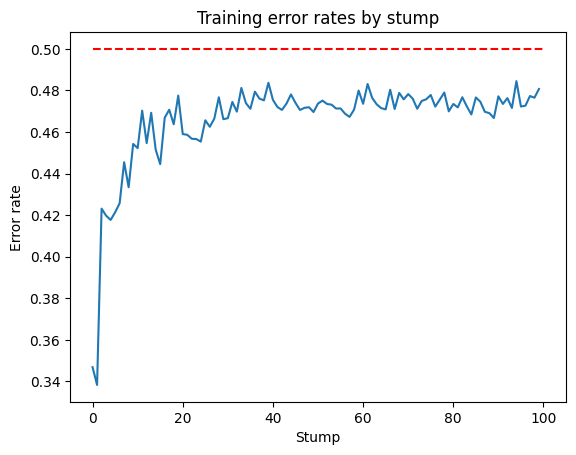

In [77]:
plt.plot(ada.errors)
plt.hlines(0.5, 0, ada.nEstimators, colors = 'red', linestyles='dashed')
plt.title('Training error rates by stump')
plt.xlabel('Stump')
plt.ylabel('Error rate')
plt.show()

# Documentação

## Variar nEstimators


In [96]:
def crossValidationError(X, y, nEstimators=100, k=5):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    errors = []

    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]

        ada.fit(X_train, y_train, nEstimators)
        y_pred = ada.predict(X_test)
        errors.append(np.sum(y_test != y_pred))

    return np.mean(errors)

In [109]:
ada = AdaBoost()

estimatorsList = [100, 200, 300, 400, 500, 600]
errors = []

for estim in estimatorsList:
    error = crossValidationError(X, y, nEstimators=estim)
    errors.append(error)


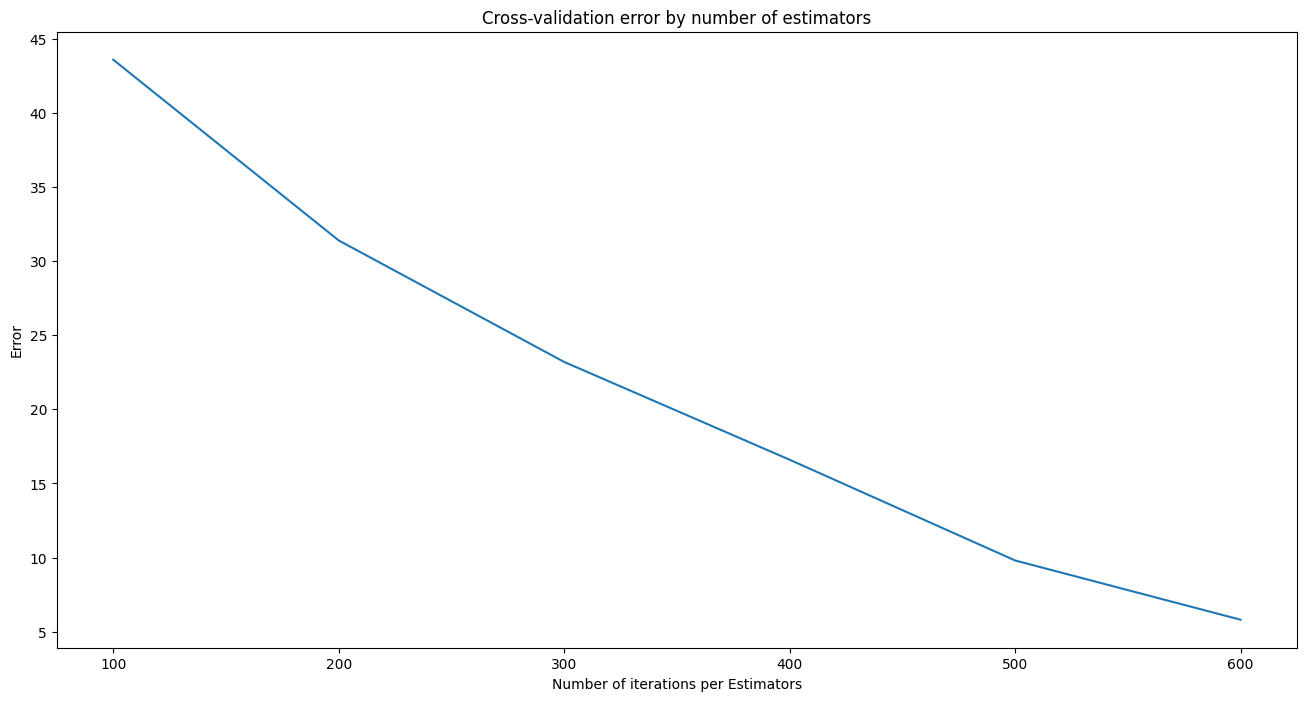

In [110]:
plt.figure(figsize=(16, 8))
plt.plot(estimatorsList, errors)
plt.title('Cross-validation error by number of estimators')
plt.xlabel('Number of iterations per Estimators')
plt.ylabel('Error')
plt.show()

## Variar maxDepth

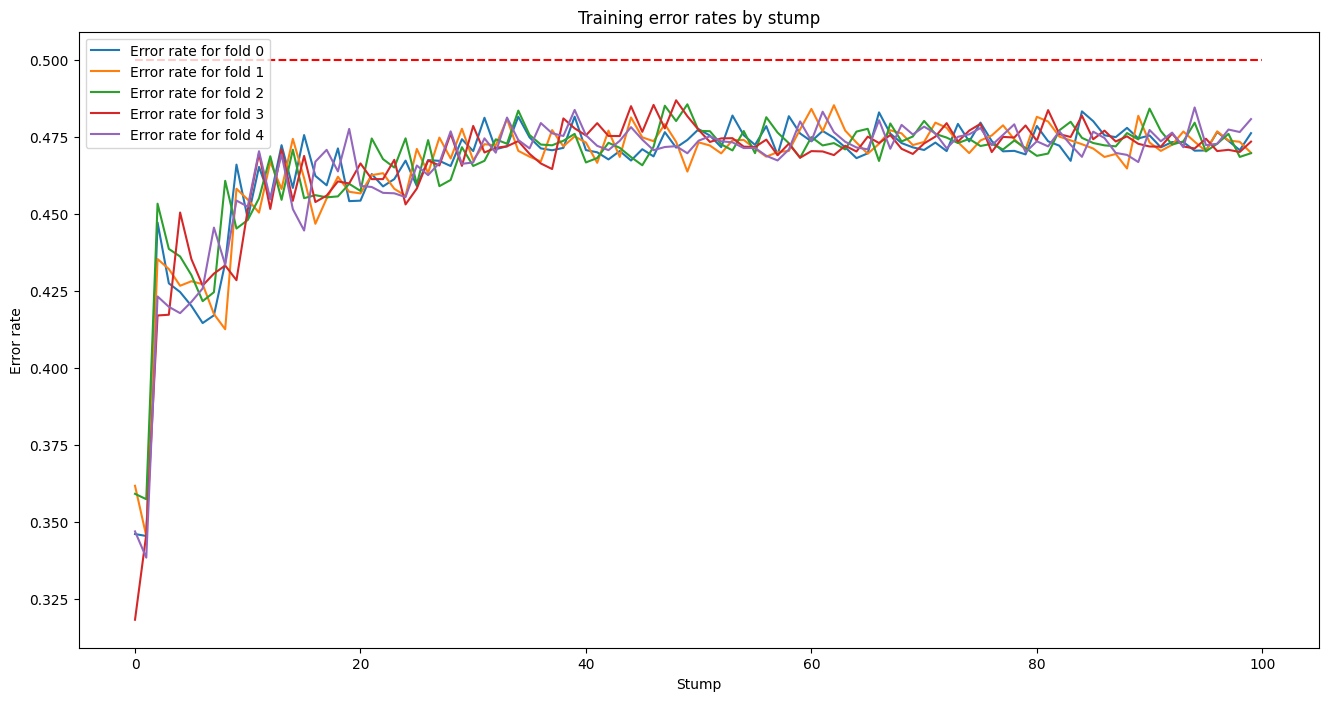

In [111]:
ada = AdaBoost()

k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)
accuracies = []

plt.figure(figsize=(16, 8))

for i, (train_index, test_index) in enumerate(kf.split(X, y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    ada.fit(X_train, y_train)
    y_pred = ada.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    plt.plot(ada.errors, label=f'Error rate for fold {i}')

plt.hlines(0.5, 0, ada.nEstimators, colors = 'red', linestyles='dashed')
plt.legend()
plt.title('Training error rates by stump')
plt.xlabel('Stump')
plt.ylabel('Error rate')
plt.show()


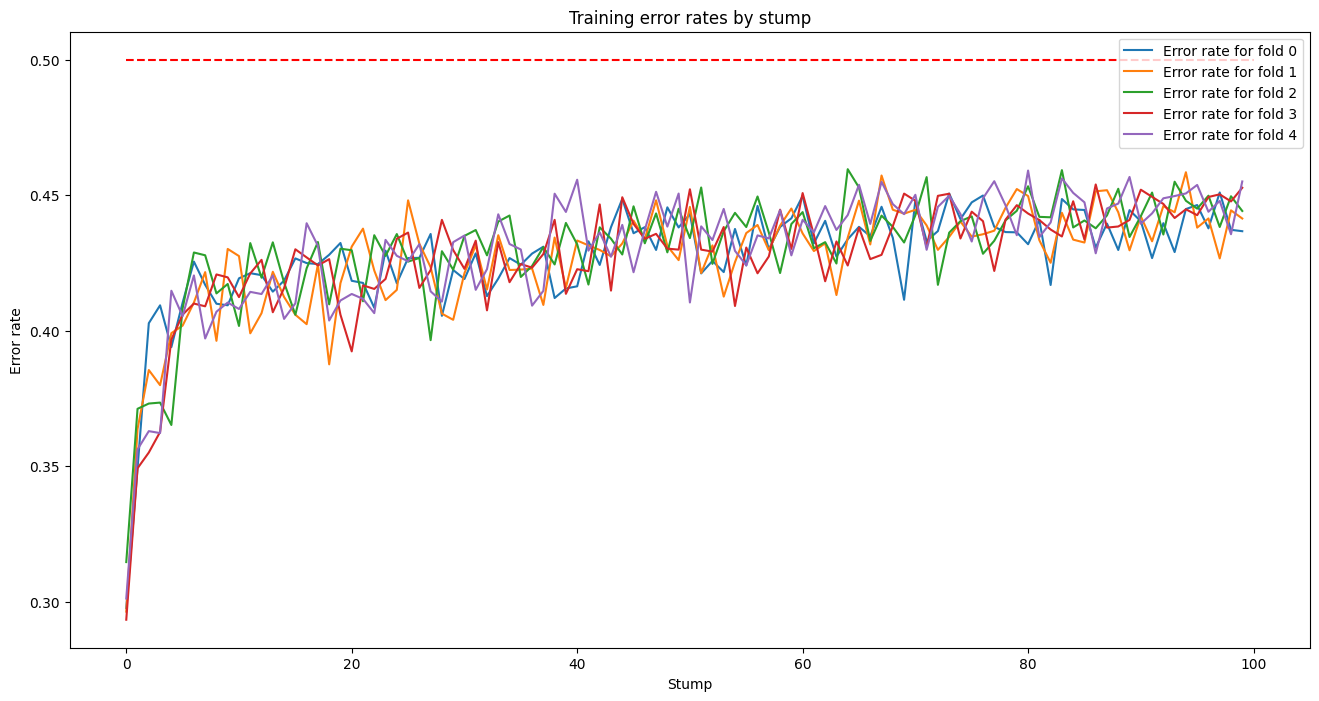

In [112]:
ada = AdaBoost(DecisionTreeClassifier(max_depth=2))

accuracies = []

plt.figure(figsize=(16, 8))

for i, (train_index, test_index) in enumerate(kf.split(X, y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    ada.fit(X_train, y_train)
    y_pred = ada.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    plt.plot(ada.errors, label=f'Error rate for fold {i}')

plt.hlines(0.5, 0, ada.nEstimators, colors = 'red', linestyles='dashed')
plt.legend()
plt.title('Training error rates by stump')
plt.xlabel('Stump')
plt.ylabel('Error rate')
plt.show()